# Generate Images from Checkpoint

I had to run this code locally because the AWS instance doesn't have enough RAM to run this (too much reserved for Pytorch). If we want to generate more than 15k samples, we may want to look into how to do so!

In [1]:
import torch
import os
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import shutil
import glob
import dlib
import numpy as np
import random
import math
import wgan_gp
import model as csagan

In [2]:
image_shape = (3, 64, 64)
n_classes = 10
n = 1500
image_path = '../resized_emoji_challenge_128_faces'
# criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
lambda_gp = 10
g_conv_dim = 64
d_conv_dim = 64
ckpt_epoch = 5
device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'
class_to_idx = {'angry': 0, 'clenched_teeth': 1, 'cringe': 2, 'disgust': 3, 'eye_roll': 4, 'here_we_go': 5, 'kiss': 6, 'sad': 7, 'surprise': 8, 'very_sad': 9}
idx_to_class = dict([(value, key) for key, value in class_to_idx.items()])

In [3]:
def set_all_seeds(seed):
#     random.seed(seed)
#     np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()
        
set_all_seeds(0)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, num_classes=n_classes)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(), y.float()), dim=1)
    return combined

In [4]:
# Adapted from https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
def load_ckpt(checkpoint_path, gen, gen_opt, disc, disc_opt):
    # load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # initialize state_dict from checkpoint
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    
    # initialize optimizers from checkpoint
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    
    return checkpoint['epoch'], gen, disc, gen_opt, disc_opt

In [5]:
def truncated_z_sample(batch_size, z_dim, truncation=0.5, seed=None, device='cpu'):
    state = None if seed is None else np.random.RandomState(seed)
    values = truncnorm.rvs(-2, 2, size=(batch_size, z_dim), random_state=state)
    values *= truncation
    values = torch.from_numpy(values).float().to(device)
    return values

def get_input_dimensions(z_dim, image_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        image_shape: the shape of each image as (C, W, H)
        n_classes: the total number of classes in the dataset, an integer scalar
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = image_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        try:
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# cSAWGAN-GP

In [6]:
root_dir = 'generated/csawgan_gp'

In [7]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)

gen = wgan_gp.Generator(image_shape[1], generator_input_dim, g_conv_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = wgan_gp.Discriminator(discriminator_im_chan, d_conv_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

start_epoch, gen, disc, gen_opt, disc_opt = load_ckpt('model_ckpt/cSAWGAN-GP/epoch_120.pth.tar', gen, gen_opt, disc, disc_opt)

In [8]:
def get_emoji_images(emoji_idx, n_images): 
    interpolation_noise = get_noise(n_images, z_dim, device=device)
    label = get_one_hot_labels(torch.Tensor([emoji_idx]).long(), n_classes).repeat(n_images, 1)
    noise_and_labels = combine_vectors(interpolation_noise, label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images = n_images, nrow=int(math.sqrt(n_images)))
    return fake

In [9]:
detector = dlib.get_frontal_face_detector()
def save_emoji_images(emoji_idx, n_images=10, base_path='generated'): 
    if not os.path.exists(base_path): 
        os.makedirs(base_path)
    emoji = idx_to_class[emoji_idx]
    shutil.rmtree(base_path + '/' + emoji, ignore_errors=True)
    os.makedirs(base_path + '/' + emoji)
    fakes = get_emoji_images(emoji_idx, n_images)
    avg = 0
    random_ints = random.sample(range(int(1e7)), len(fakes))
    for i in range(fakes.shape[0]): 
        save_image(fakes[i], '{}/{}/{:09}.jpg'.format(base_path, emoji, random_ints[i]))
    print(f'{emoji}: {avg}')

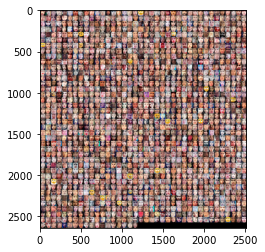

angry: 0


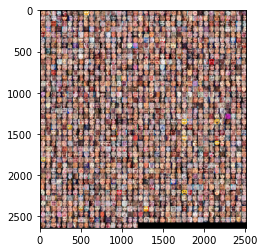

clenched_teeth: 0


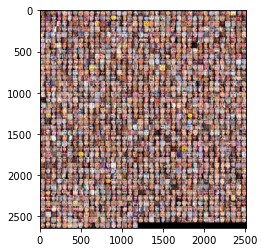

cringe: 0


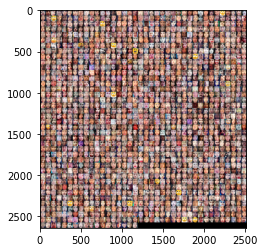

disgust: 0


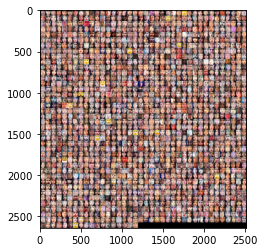

eye_roll: 0


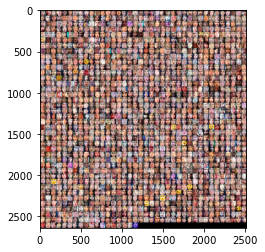

here_we_go: 0


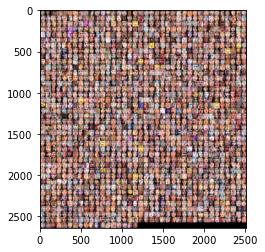

kiss: 0


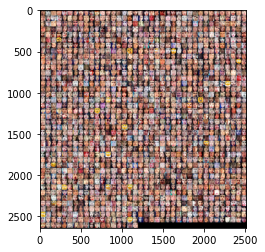

sad: 0


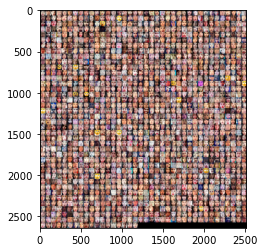

surprise: 0


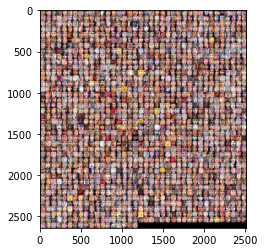

very_sad: 0


In [10]:
for key in idx_to_class: 
    save_emoji_images(key, n_images=n, base_path=root_dir)

In [11]:
avg = 0
not_faces = 0
# root_dir needs a trailing slash (i.e. /root/dir/)
for filename in glob.iglob(root_dir + '/**/*.jpg', recursive=True):
    img = dlib.load_rgb_image(filename)
    try:
        dets, scores, idx = detector.run(img, 1, -1)
        avg += (sum(scores)/len(scores))/(n*n_classes)
        if (sum(scores)/len(scores)) < 0.27: 
            os.remove(filename)
    except: 
        not_faces += 1
        os.remove(filename)
print(avg)
print(not_faces)

0.3383478050076305
408


In [12]:
for folder in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(root_dir, folder)))}')

here_we_go: 814
kiss: 706
disgust: 863
cringe: 866
sad: 787
angry: 873
surprise: 867
clenched_teeth: 820
eye_roll: 795
very_sad: 841


# cSAGAN

In [18]:
root_dir = 'generated/csagan'

In [19]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)

gen = csagan.Generator(image_shape[1], generator_input_dim, g_conv_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = csagan.Discriminator(discriminator_im_chan, d_conv_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

start_epoch, gen, disc, gen_opt, disc_opt = load_ckpt('model_ckpt/cSAGAN/epoch_95.pth.tar', gen, gen_opt, disc, disc_opt)

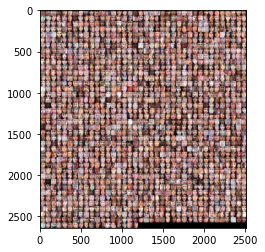

angry: 0


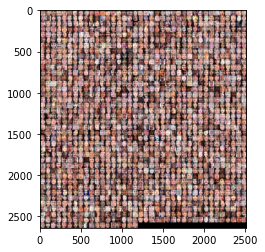

clenched_teeth: 0


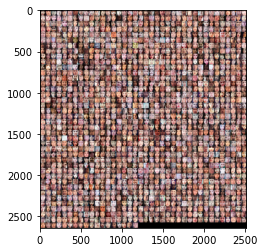

cringe: 0


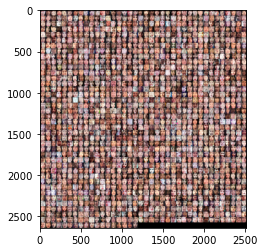

disgust: 0


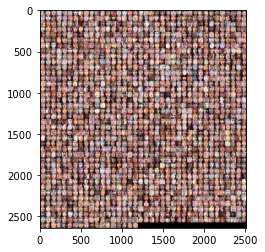

eye_roll: 0


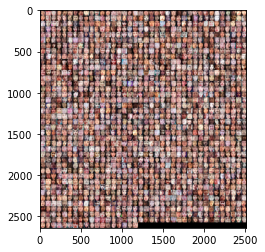

here_we_go: 0


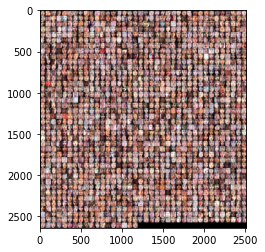

kiss: 0


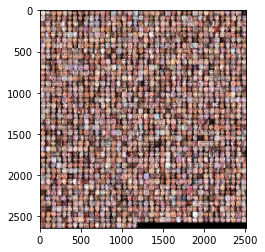

sad: 0


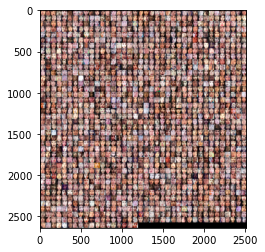

surprise: 0


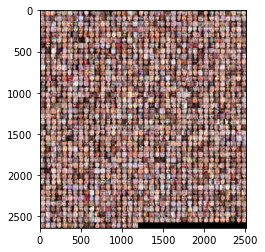

very_sad: 0


In [20]:
for key in idx_to_class: 
    save_emoji_images(key, n_images=n, base_path=root_dir)

In [21]:
avg = 0
not_faces = 0
# root_dir needs a trailing slash (i.e. /root/dir/)
for filename in glob.iglob(root_dir + '/**/*.jpg', recursive=True):
    img = dlib.load_rgb_image(filename)
    try:
        dets, scores, idx = detector.run(img, 1, -1)
        avg += (sum(scores)/len(scores))/(n*n_classes)
        if (sum(scores)/len(scores)) < 0.27: 
            os.remove(filename)
    except: 
        not_faces += 1
        os.remove(filename)
print(avg)
print(not_faces)

0.19674673332497566
725


In [22]:
for folder in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, folder)):
        print(f'{folder}: {len(os.listdir(os.path.join(root_dir, folder)))}')

here_we_go: 675
kiss: 541
disgust: 710
cringe: 707
sad: 650
angry: 663
surprise: 661
clenched_teeth: 659
eye_roll: 665
very_sad: 685
